<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Improved Neural Network Strategy

## Importing the required libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tpqoa ## https://github.com/yhilpisch/tpqoa
import tensorflow as tf
from tensorflow import keras

In [43]:
def set_seeds(seed=500):
    ''' Function to set seeds for all
        random number generators.
    '''
#    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seeds()

### Graph Formating

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

In [3]:
api = tpqoa.tpqoa('../config.cfg')

In [27]:
'''
Parameters
==========
instrument: string
    valid instrument name
start, end: datetime, str
    Python datetime or string objects for start and end
granularity: string
    a string like 'S5', 'M1' or 'D'
price: string
    one of 'A' (ask) or 'B' (bid)
'''
instrument = 'USD_CAD'
start = '2020-02-01'
end = '2020-07-31'
granularity = 'M30'
price = 'M'

In [28]:
filename = f'../oanda/' 
filename += f'oanda_{instrument}_{start}_{end}_'
filename += f'{granularity}_{price}.csv'
filename = filename.replace(' ', '_').replace('-', '_').replace(':', '_')
try:
    rawdata = pd.read_csv(filename, index_col=0, parse_dates=True)
except:
    rawdata = api.get_history(instrument, start,
                               end, granularity,
                               price)
    rawdata.to_csv(filename)
    print(60*"=")
    print("Created CSV File")
    print(filename)
    print(60*"=")

In [7]:
rawdata = pd.DataFrame(rawdata['c'])
rawdata.columns = ['price']

In [8]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6195 entries, 2020-02-02 22:00:00 to 2020-07-30 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6195 non-null   float64
dtypes: float64(1)
memory usage: 96.8 KB


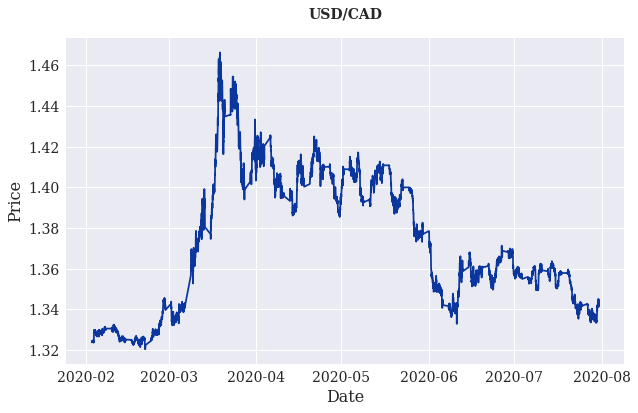

In [9]:
plt.figure()
plt.title('USD/CAD',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(rawdata['price'], color='#0A369D');
# plt.savefig('price.png', facecolor='None')

In [10]:
data = rawdata[:-1].copy()
data['returns'] = np.log(data/data.shift(1))
data['direction'] = np.where(data['returns'] > 0 , 1,0)


# Calculates Simple Moving Averages with a long and a short window
data['SMA1'] = data['price'].rolling(20).mean().shift(1)
data['SMA2'] = data['price'].rolling(60).mean().shift(1)
data['dSMA'] = data['SMA1'] - data['SMA2']

# Calculates Equally Weighted Moving Average with a long and a short halflife
data['EWMA1'] = data['price'].ewm(halflife=20).mean().shift(1)
data['EWMA2'] = data['price'].ewm(halflife=60).mean().shift(1)
data['dEWMA'] = data['EWMA1'] - data['EWMA2']

# Calculates the moving standard deviation
data['vol1'] = data['price'].rolling(20).std().shift(1)
data['vol2'] = data['price'].rolling(60).std().shift(1)

# Deletes NA rows
data.dropna(inplace=True)

data.tail()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
time,,,,,,,,,,,
2020-07-30 21:00:00,1.34280,0.000447,1,1.343143,1.338618,0.004525,1.340118,1.338876,0.001241,0.001180,0.003988
2020-07-30 21:30:00,1.34272,-0.000060,0,1.343209,1.338729,0.004480,1.340209,1.338921,0.001288,0.001117,0.004010
2020-07-30 22:00:00,1.34222,-0.000372,0,1.343282,1.338823,0.004459,1.340295,1.338965,0.001330,0.001027,0.004037
2020-07-30 22:30:00,1.34192,-0.000224,0,1.343299,1.338901,0.004398,1.340360,1.339003,0.001358,0.001005,0.004057
2020-07-30 23:00:00,1.34156,-0.000268,0,1.343277,1.338981,0.004296,1.340413,1.339036,0.001377,0.001031,0.004069


As a good practice, we split the data in training (70%) and test (30%) to evaluate our final model with data that the model hasn't seen.

In [11]:
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [12]:
train.shape

(4293, 11)

In [13]:
test.shape

(1841, 11)

In [14]:
#Creating the lags
features = list(data.columns)
cols = list(data.columns)
for f in features:    
    #Create lags
    for lag in range(1, 5 + 1):
        col = f'{f}_lag_{lag}'
        cols.append(col)
        train[col] = train[f].shift(lag)
        test[col] = test[f].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)   

In [15]:
#Normalizes variables
for f in cols:    
    if 'rets' not in f and 'direction' not in f:
        Tmean = train[f].mean()
        Tstd  = train[f].std()
        train[f]= (train[f] - Tmean) / Tstd
        test[f] = (test[f]  - Tmean) / Tstd    

For simplicity at the moment of the modelling process, we divided the data frames into two.
The `X` that represent the features and `y` is the target variable to forecast.

In [16]:
y_train = pd.DataFrame(train['direction'])
y_test = pd.DataFrame(test['direction'])
X_train = train.drop(columns=['direction','returns','price']).copy()
X_test = test.drop(columns=['direction','returns','price']).copy()

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4288 entries, 2020-02-04 06:30:00 to 2020-06-08 14:30:00
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMA1             4288 non-null   float64
 1   SMA2             4288 non-null   float64
 2   dSMA             4288 non-null   float64
 3   EWMA1            4288 non-null   float64
 4   EWMA2            4288 non-null   float64
 5   dEWMA            4288 non-null   float64
 6   vol1             4288 non-null   float64
 7   vol2             4288 non-null   float64
 8   price_lag_1      4288 non-null   float64
 9   price_lag_2      4288 non-null   float64
 10  price_lag_3      4288 non-null   float64
 11  price_lag_4      4288 non-null   float64
 12  price_lag_5      4288 non-null   float64
 13  returns_lag_1    4288 non-null   float64
 14  returns_lag_2    4288 non-null   float64
 15  returns_lag_3    4288 non-null   float64
 16  returns_lag_4    4288 no

Finally, we split the training data frame into training and validation so we can use that 2nd validation to fine-tune our model before making the final decision of our model with the test data frame.

In [18]:
split = int(len(X_train) * 0.7)
partial_X_train = X_train.iloc[split:].copy()
X_val = X_train.iloc[:split].copy()
partial_y_train = y_train.iloc[split:].copy()
y_val = y_train.iloc[:split].copy()

## Modelling the Neural Network

In [19]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dropout

Using TensorFlow backend.


In [20]:
model = Sequential()
    
model.add(Dense(64, input_dim=63, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  
    
model.compile(loss='binary_crossentropy',  
                       optimizer='adam',  
                       metrics=['acc'])  

In [21]:
history = model.fit(partial_X_train, 
                          partial_y_train, 
                          epochs=30, 
                          verbose=False,
                          validation_data=(X_val,y_val))

In [22]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

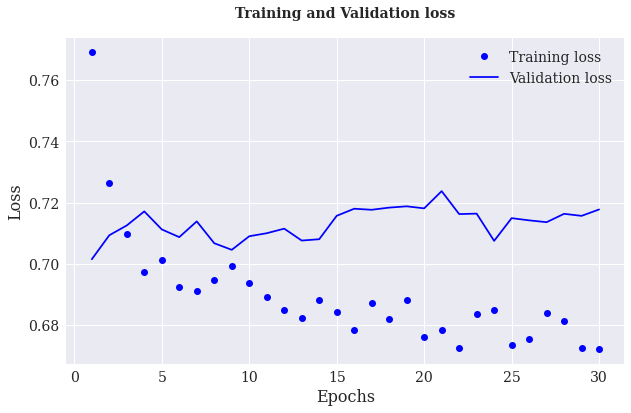

In [23]:
plt.plot(epochs, loss_values,'bo', label='Training loss')
plt.plot(epochs, val_loss_values,'b', label='Validation loss')
plt.title('Training and Validation loss',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
# plt.savefig('Loss.png', facecolor='None')

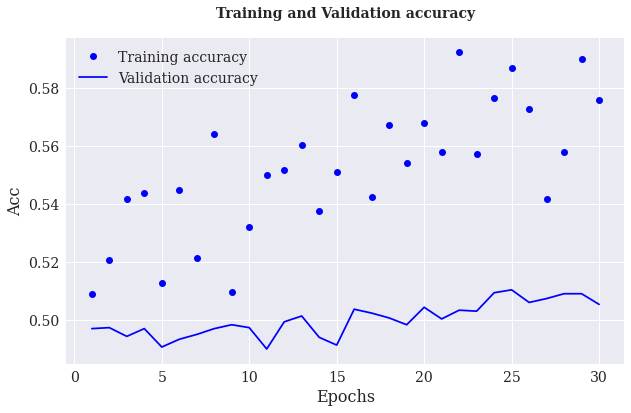

In [24]:
plt.plot(epochs, acc_values,'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values,'b', label='Validation accuracy')
plt.title('Training and Validation accuracy',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend();
# plt.savefig('Accuracy.png', facecolor='None')